# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [15]:
#%%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None,
                 init='random', tol=1e-4, verbose=False, early_stop=True):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.X = None
        self.early_stop = early_stop

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        self.X = X
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        if self.init == 'random':
            self.centroids = X[np.random.choice(
                X.shape[0], self.k, replace=False)]
        elif self.init == 'k-means':
            self.centroids = self._k_means_plus_plus_init()
        else:
            raise ValueError("No such init method")
        loss = np.inf
        for i in range(self.max_iter):
            self.labels = cdist(X, self.centroids).argmin(axis=1)
            prev_loss = loss
            self.centroids = np.array(
                [X[self.labels == k].mean(axis=0) for k in range(self.k)])

            if self.early_stop:
                loss = self._calculate_loss()
                if self.verbose:
                    print("Loss on {0}: {1}".format(i, loss))
                if abs(prev_loss - loss) < self.tol:
                    break
        return self

    def _calculate_loss(self):
        loss = 0
        for k in range(self.k):
            X_k = self.X[self.labels == k]
            # print((pdist(X_k)**2).sum())
            loss += (np.linalg.norm(X_k - self.centroids[k], axis=1)**2).sum()
        return loss

    def _k_means_plus_plus_init(self):
        self.centroids[0] = self.X[np.random.choice(self.X.shape[0])]
        for i in range(1, self.k):
            d2 = np.min(cdist(self.X, self.centroids[:i])**2, axis=1)
            probs = d2 / d2.sum()
            cumprobs = probs.cumsum()
            x = np.random.rand()
            idx = np.searchsorted(cumprobs, x, side="left")
            self.centroids[i] = self.X[idx]
        return self.centroids

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        return cdist(X, self.centroids).argmin(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self, batch_size=32, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random',
                 tol=1e-2, verbose=False, early_stop=True):
        self.batch_size = batch_size
        super().__init__(k, metric, max_iter, random_state, init, tol,
                         verbose, early_stop)

    def fit(self, X, y=None):
        self.X = X
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))

        if self.init == 'random':
            self.centroids = X[np.random.choice(
                X.shape[0], self.k, replace=False)]
        elif self.init == 'k-means':
            self.centroids = self._k_means_plus_plus_init()
        else:
            raise ValueError("No such init method")

        count_centroids = np.zeros(self.k)

        old_centroids = np.empty((self.k, X.shape[1]))

        loss = np.inf
        for i in range(self.max_iter):
            prev_loss = loss
            batch_indx = np.random.choice(
                X.shape[0], self.batch_size, replace=False)
            X_batch = X[batch_indx]
            batch_labels = cdist(X_batch, self.centroids).argmin(axis=1)
            for j in range(X_batch.shape[0]):
                centroid = batch_labels[j]
                count_centroids[centroid] += 1
                learning_step = 1 / count_centroids[centroid]
                self.centroids[centroid] = (
                    1 - learning_step) * self.centroids[centroid] + \
                    learning_step * X_batch[j]
            if self.early_stop:
                self.labels = cdist(X, self.centroids).argmin(axis=1)
                loss = self._calculate_loss()
                if self.verbose:
                    print("Loss on {0}: {1}".format(i, loss))
                if abs(prev_loss - loss) < self.tol:
                    break
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [16]:
from sklearn.datasets import make_blobs

In [17]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

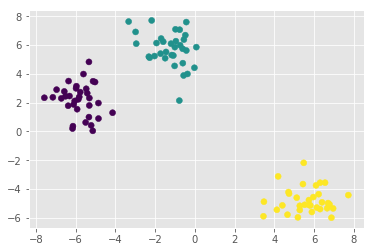

In [18]:
plt.scatter(X[:,0], X[:, 1], c=y)

Current clf is  K-Means
10.9 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
17.9 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
47 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
232 ms ± 9.74 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
414 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
916 ms ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
Current clf is  K-means++
12.7 ms ± 855 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)
20.1 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)
53.7 ms ± 974 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)
267 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
429 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
850 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
Current clf is  Mini-Batch K-Means
33.8 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
31 ms ± 876 µs p

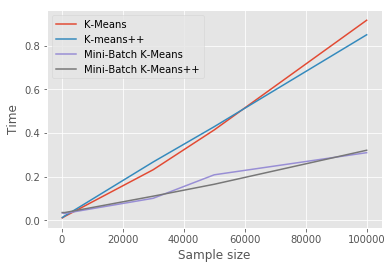

In [20]:
# Задание 4
import timeit
dataset_sizes = [200, 1000, 5000, 30000, 50000, 100000]

params = {"k": 3, "max_iter": 100, "early_stop": False, "random_state": 332}
clfs = [(MyKmeans(**params), 'K-Means'), 
        (MyKmeans(init='k-means', **params), 'K-means++'),
        (MiniBatchKMeans(**params), 'Mini-Batch K-Means'),
        (MiniBatchKMeans(init='k-means', **params), 'Mini-Batch K-Means++')]
for clf in clfs:
    print("Current clf is ", clf[1])
    times = []
    for size in dataset_sizes:
        data, _ = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1,
                             center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
        time_it = %%timeit -n 2 -o clf[0].fit(data)
        times.append(time_it.average)
    plt.plot(dataset_sizes, times, label=clf[1])
plt.legend()
plt.xlabel("Sample size")
plt.ylabel("Time")
plt.show()

## Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

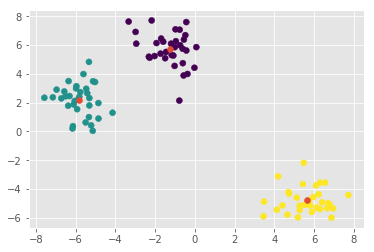

In [21]:
## Работоспособность MyKmeans
clf = MyKmeans(k=3, random_state=332, verbose=False)
clf.fit(X)
pred = clf.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])
plt.show()

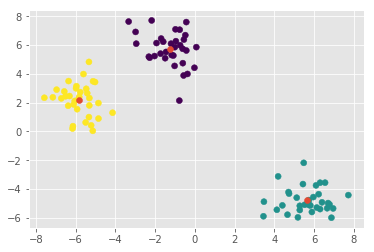

In [22]:
## Работоспособность MyKmeans++
clf = MyKmeans(k=3, random_state=332, init='k-means', verbose=False)
clf.fit(X)
pred = clf.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])
plt.show()

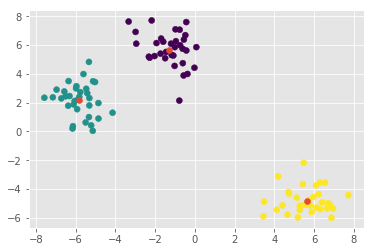

In [23]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
clf = MiniBatchKMeans(k=3, random_state=332, verbose=False)
clf.fit(X)
pred = clf.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])
plt.show()

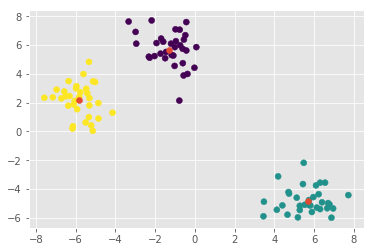

In [24]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchKMeans(k=3, random_state=332, init='k-means', verbose=False)
clf.fit(X)
pred = clf.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])
plt.show()

In [25]:
## Время выполнения алгоритма Kmeans из sklearn
clf = KMeans(n_clusters=3, max_iter=1000, random_state=332)
%timeit clf.fit(X, y)

20.4 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
## Время выполнения алгоритма MyKmeans
clf = MyKmeans(k=3, random_state=332)
%timeit clf.fit(X, y)

703 µs ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
## Время выполнения алгоритма MyKmeans++
clf = MyKmeans(k=3, random_state=332, init='k-means')
%timeit clf.fit(X, y)

583 µs ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
clf = MiniBatchKMeans(k=3, random_state=332)
%timeit clf.fit(X, y)

8.34 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchKMeans(k=3, random_state=332, init='k-means')
%timeit clf.fit(X, y)

7.58 ms ± 61.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [30]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [31]:
df_sns_drop = df_sns.drop(columns=['gradyear', 'gender', 'age', 'friends']) # 36 ключевые слова
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sns_drop) # Нормализация данных
col_names = df_sns_drop.columns

In [32]:
def plot_cluster_interpretation(centroids, pred):
    df = pd.DataFrame(data=centroids, columns=col_names)
    fig, ax = plt.subplots(3, 3, figsize=(20, 12))
    cluster_num = 0
    for i in range(len(ax)):
        h_ax = ax[i]
        for j in range(len(h_ax)):
            cluster_size = pred[pred==cluster_num].size
            df_sorted_by_importance = df.iloc[cluster_num].sort_values(ascending=False)[:5]
            ax[i][j].set_title("Cluster: {0}. Size: {1}".format(cluster_num, cluster_size))
            sns.barplot(df_sorted_by_importance.values, df_sorted_by_importance.index, ax=ax[i][j])
            cluster_num += 1

KMeans within-cluster sum of squares 868019.116676942


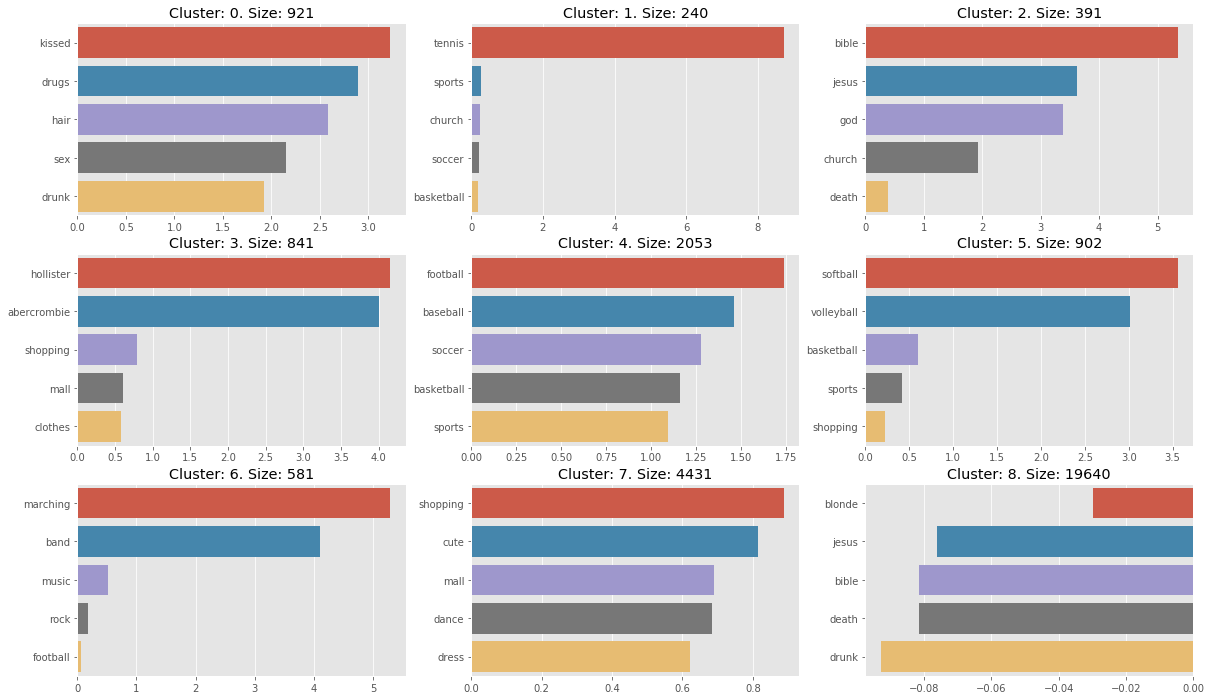

In [33]:
## MyKMeans
clf = MyKmeans(k=9, random_state=123, verbose=False)
clf.fit(df_scaled)
pred = clf.predict(df_scaled)
print("KMeans within-cluster sum of squares", clf._calculate_loss())
plot_cluster_interpretation(clf.centroids, pred)

Mini KMeans++ within-cluster sum of squares 867409.1989900881


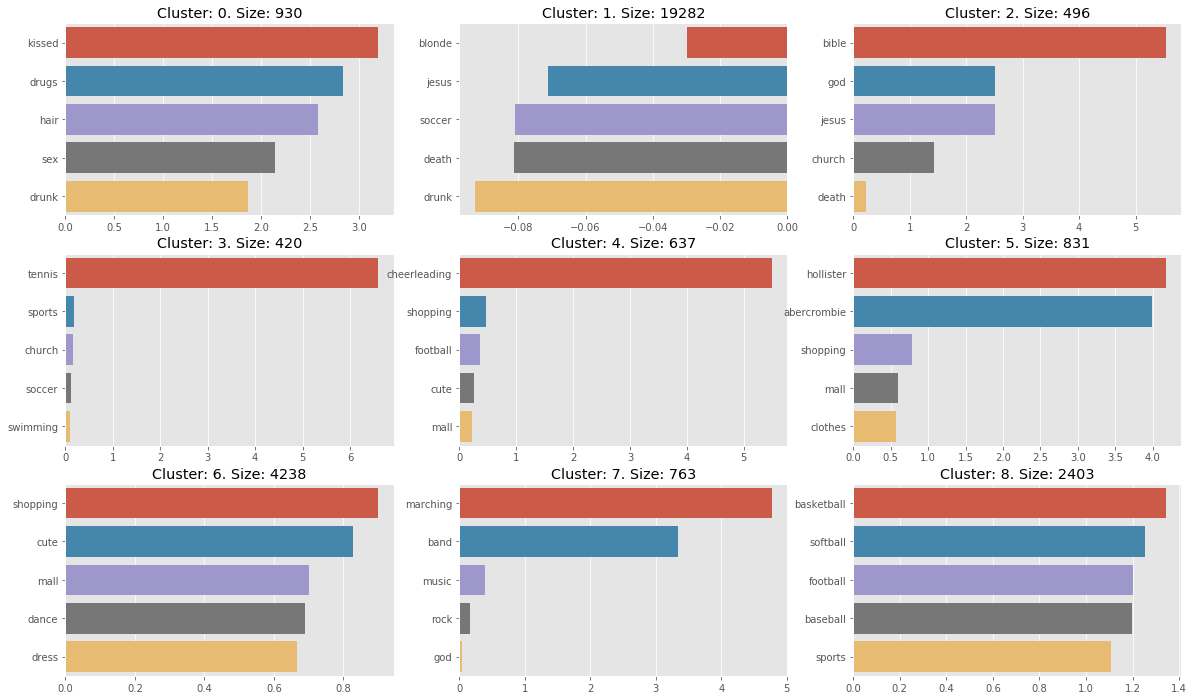

In [34]:
## MyKMeans++
clf = MyKmeans(k=9, random_state=123, init='k-means', verbose=False)
clf.fit(df_scaled)
pred = clf.predict(df_scaled)
print("Mini KMeans++ within-cluster sum of squares", clf._calculate_loss())
plot_cluster_interpretation(clf.centroids, pred)

KMeans++ within-cluster sum of squares 892026.852876239


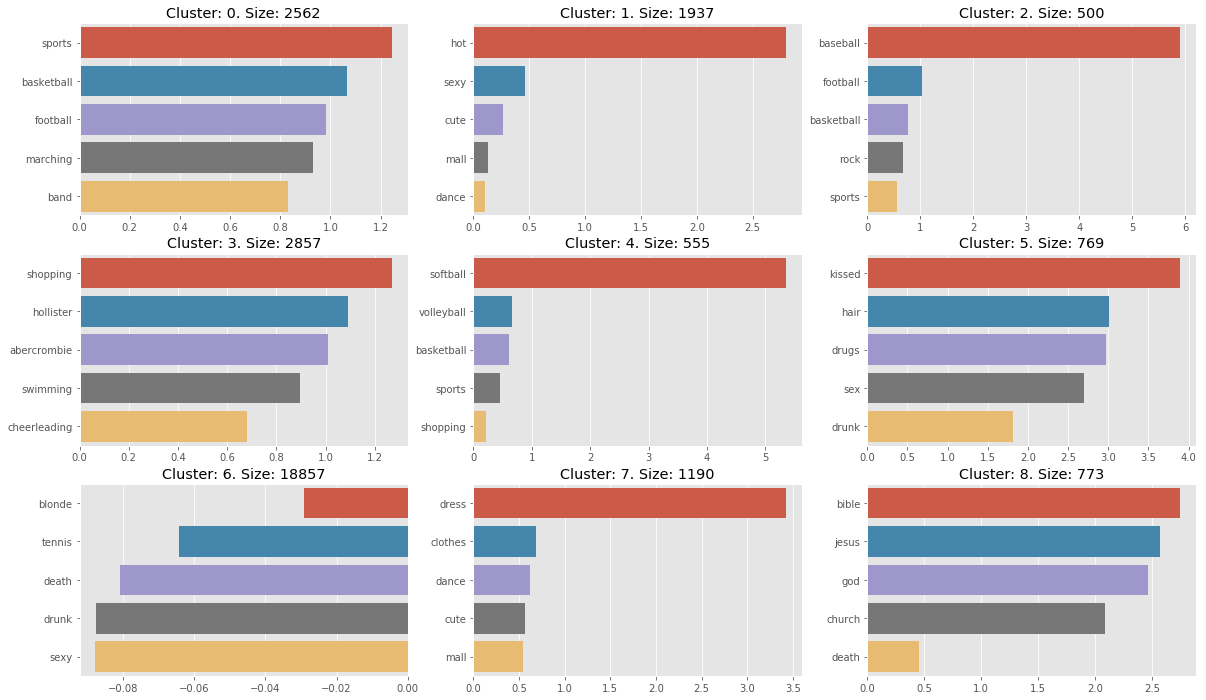

In [35]:
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=9, random_state=332, tol=1, batch_size=2000, verbose=False)
clf.fit(df_scaled)
pred = clf.predict(df_scaled)
print("KMeans++ within-cluster sum of squares", clf._calculate_loss())
plot_cluster_interpretation(clf.centroids, pred)

Mini KMeans within-cluster sum of squares 891567.9711694645


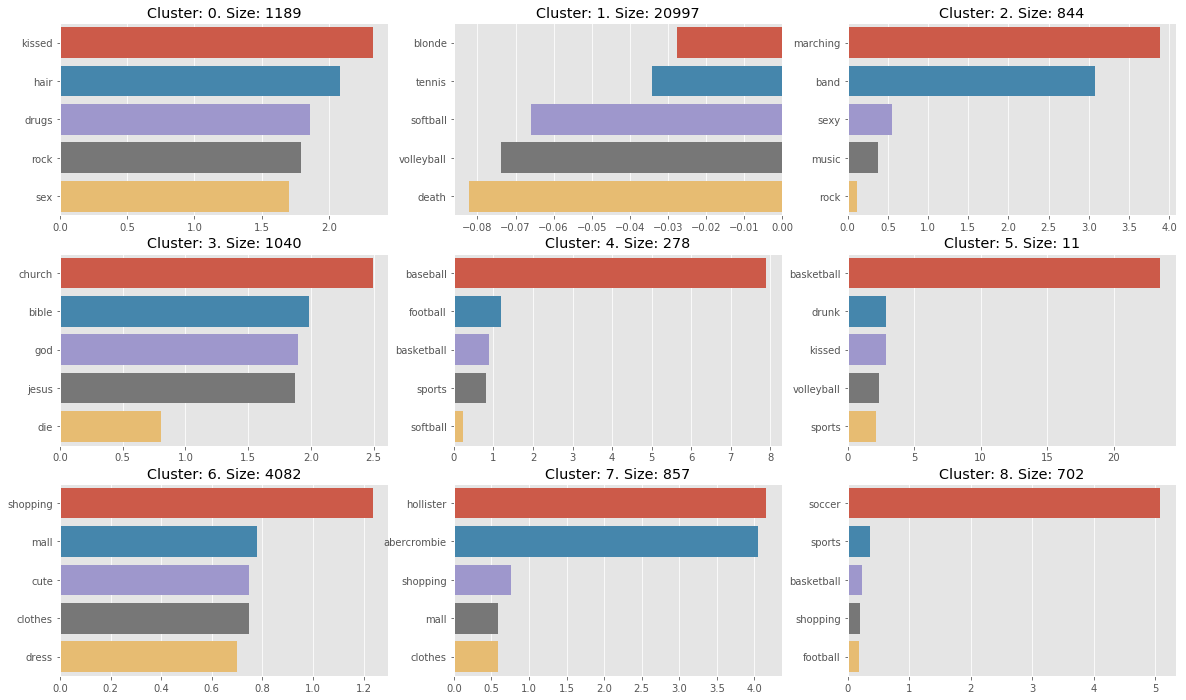

In [36]:
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=9, random_state=332, tol=1, init='k-means', batch_size=2000, verbose=False)
clf.fit(df_scaled)
pred = clf.predict(df_scaled)
print("Mini KMeans within-cluster sum of squares", clf._calculate_loss())
plot_cluster_interpretation(clf.centroids, pred)

Попробуем проинтерпретировать кластеры. Будем использовать результаты K-means++, т.к он имеет наименьший WCSS:
* Cluster 0. Тусовщики
* Cluster 1. Большинство людей с обычными интересами
* Cluster 2. Верующие
* Cluster 3. Теннисисты
* Cluster 4. Чирлидеры
* Cluster 5. Люди, которые следят за модой
* Cluster 6. Милые девушки, занимающиеся шоппингом
* Cluster 7. Музыканты, рокеры
* Cluster 8. Спортсмены

## Вывод
На данных facebook'a алгоритмы работают приблизительно одинаково (Minibatch k-means'ы чуть хуже). Критериями выбора были WCSS, интерпретируемость и то, что кластеры содержат хотя бы по 100 объектов.
Выводы из моего опыта реализации и тестов:
* Алгоритмы K-means и Minibatch K-means довольно сильно зависит от инициализации (сходимость в разные локальные минимумы), вплоть до того, что кластер может не иметь данных.
* K-means++ решает вышеуказанную проблему инициализируя центройды ближе к реальным кластерам.
* Minibatch алгоритмы работают быстро при большом количестве данных, но при этом имеют медленную сходимость.
* Алгоритмы используют l2 норму, а значит подвержены проклятью размерности 